In [1]:
import slem
from slem import DAGLearner
import pandas as pd
import os
import tqdm
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import seaborn as sns
from scipy.special import expit, logit
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
data_fn = 'data'
results_fn = 'results'
plots_fn = 'simulation_tests'


In [2]:
def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))


def gen_simple_linear_confounder(N):
    uz = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)

    Z = uz
    xp = sigm(0.7 * Z + ux)
    X = np.random.binomial(1, xp, (N, 1))

    Y1 = -0.7 + 0.8 * Z + uy  # total effect = -0.7
    Y0 =  0.8 * Z + uy  # total effect = -0.7
    Y = Y1 * X + Y0 * (1 - X)

    all_data = pd.DataFrame(np.concatenate([Z, X, Y], 1))
    all_data.columns = ['Z', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z', 'X'), ('X', 'Y'), ('Z', 'Y')])
    return all_data, DAGnx, var_types, Y1, Y0

def gen_linear_many_confounders(N):
    
    uz1 = np.random.randn(N, 1)
    uz2 = np.random.randn(N, 1)
    uz3 = np.random.randn(N, 1)
    uz4 = np.random.randn(N, 1)
    uz5 = np.random.randn(N, 1)
    uz6 = np.random.randn(N, 1)
    uz7 = np.random.randn(N, 1)
    uz8 = np.random.randn(N, 1)
    uz9 = np.random.randn(N, 1)
    uz10 = np.random.randn(N, 1)
    uz11 = np.random.randn(N, 1)
    uz12 = np.random.randn(N, 1)   
    
    # correlated confounders
    Z1 = uz1
    Z2 = uz2
    Z3 = uz3
    Z4 = 0.1 * Z3 + uz4
    Z5 = -0.2 * Z2 + uz5
    Z6 = -.3 * Z5 + uz6
    Z7 = uz7
    Z8 = 0.5 * Z7 + uz8
    Z9 = uz9
    Z10 = 0.4 * Z9 + uz10
    Z11 = 0.5 * Z10 + uz11
    Z12 = uz12
    
    
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)
    xp = sigm(0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + ux)
    X = np.random.binomial(1, xp, (N, 1))

    Y1 = -0.7 + 0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + uy
    Y0 =  0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + uy
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9, Z10, Z11, Z12, X, Y], 1))
    all_data.columns = ['Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10','Z11','Z12', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z1': 'cont','Z2': 'cont', 'Z3': 'cont', 'Z4': 'cont', 'Z5': 'cont', 
                 'Z6': 'cont', 'Z7': 'cont', 'Z8': 'cont', 'Z9': 'cont', 'Z10': 'cont', 
                 'Z11': 'cont', 'Z12': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z3', 'Z4'),('Z2', 'Z5'),('Z5', 'Z6'),('Z7', 'Z8'),('Z9', 'Z10'),
                          ('Z10', 'Z11'),('Z1', 'X'), ('Z2', 'X'),('Z3', 'X'),('Z4', 'X'),('Z5', 'X'),
                          ('Z6', 'X'),('Z7', 'X'),('Z8', 'X'),('Z9', 'X'),('Z10', 'X'),
                          ('Z11', 'X'),('Z12', 'X'),('Z1', 'Y'), ('Z2', 'Y'),('Z3', 'Y'),
                          ('Z4', 'Y'),('Z5', 'Y'),('Z6', 'Y'),('Z7', 'Y'),('Z8', 'Y'),
                          ('Z9', 'Y'),('Z10', 'Y'),('Z11', 'Y'),('Z12', 'Y'),('X', 'Y'),])
    return all_data, DAGnx, var_types, Y1, Y0



def gen_simple_nonlinear_confounder(N):
    
    uz1 = np.random.randn(N, 1)
    uz2 = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)

    Z1 = uz1
    Z2 = uz2
    
    xp = sigm(0.7 * Z1 + 0.4 * Z1*Z2 + 0.4 *Z2 + ux)
    X = np.random.binomial(1, xp, (N, 1))
    
    Y0 = 0.3 + 0.8 * Z1 + 0.3 * Z1*Z2 + 0.5*Z2**2 + uy
    Y1 = 0.3 + 1.5 + 0.8 * Z1 + 0.3 * Z1*Z2 + 0.5*Z2**2 + uy
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([Z1, Z2, X, Y], 1))
    all_data.columns = ['Z1', 'Z2', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z1': 'cont','Z2': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z1', 'X'), ('Z2', 'X'),('X', 'Y'), ('Z1', 'Y'), ('Z2', 'Y')])
    return all_data, DAGnx, var_types, Y1, Y0

def gen_simple_linear_mediation(N):
    um = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)
    
    X = ux
    xp = sigm(ux)
    X = np.random.binomial(1, xp, (N, 1))
    
    m1 = 0.8 + um  
    m0 = um
    
    M = m1 * X + m0 * (1 - X)

    Y1 = 0.5 + 0.8 * m1 + uy   # direct effect = 0.5, indirect = 0.8 * 0.8, total = 1.14
    Y0 = 0.8 * m0 + uy  
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([X, M, Y], 1))
    all_data.columns = ['X', 'M', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'M': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('X', 'M'), ('M', 'Y'), ('X', 'Y')])
    return all_data, DAGnx, var_types, Y1, Y0



def gen_simple_poly(N, p, degree=3):
    uy = np.random.randn(N,1)
    X2 = np.random.randn(N, 1)
    # Generate 1000 random X1, X2 values
    X1 = 0.5 * X2 + np.random.uniform(-10, 10, (N,1))
    
    poly = PolynomialFeatures(degree)
    X1_t = poly.fit_transform(X1)
    
    min_p = p - 0.666*p
    poly_coeffs = np.arange(min_p, p, (p-min_p)/degree)[::-1]
    coeff = 0.7
    all_coeffs = np.concatenate([np.array([coeff]), poly_coeffs])

    Y = (all_coeffs*X1_t).sum(1, keepdims=True) + 0.0 * X2 + uy

    all_data = pd.DataFrame(np.concatenate([X1, X2, Y], 1))
    all_data.columns = ['X1', 'X2', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X1': 'cont', 'X2': 'cont', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('X1', 'Y'), ('X2', 'Y')])
    return all_data, DAGnx, var_types

# Simple linear confounder estimation

In [4]:
k = 5
trials = 70
N = [50, 100, 250, 500, 1000, 5000]


seed = 42
np.random.seed(seed)
true_empirical_ATEs = {}
results = {}
for n in N:
    print("Simulating with sample size:", n)
    true_emps = []
    estATEs = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types, Y1, Y0  = gen_simple_linear_confounder(n)
        true_emps.append((Y1-Y0).mean())
        df.to_csv(os.path.join(data_fn, 'simple_linear_confounder_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG, k=k, var_types=var_types)
        # fit the daglearner:
        daglearner.fit(data=df, verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        estATEs.append(estATE)
    
    
    estATEs = np.asarray(estATEs)    
    results[n] = estATEs
    true_emps = np.asarray(true_emps)
    true_empirical_ATEs[n] = true_emps

results_df = []
for N, coeffs in results.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_linear_confounder_daglearner_results.csv'), index=False) 

true_df = []
for N, ates in true_empirical_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_linear_confounder_empirical_ate.csv'), index=False) 

Simulating with sample size: 50
Simulating with sample size: 100
Simulating with sample size: 250
Simulating with sample size: 500
Simulating with sample size: 1000
Simulating with sample size: 5000


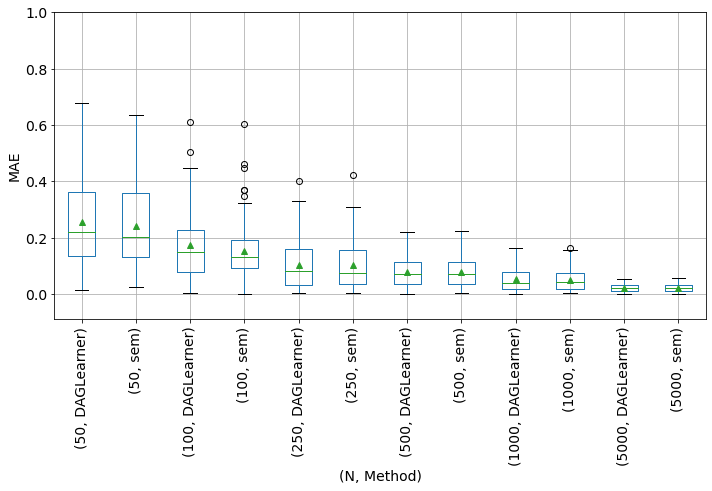

In [5]:
# import equivalent results from lavaan/R, truth, and daglearn results
results_truth = pd.read_csv(os.path.join(results_fn, 'simple_linear_confounder_empirical_ate.csv'))
results_df = pd.read_csv(os.path.join(results_fn, 'simple_linear_confounder_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_linear_confounder_sem_results.csv'))
results_df_R['mae'] = abs(results_df_R['coeff'] - results_truth['emp_ate'])
results_df['mae'] = abs(results_df['coeff'] - results_truth['emp_ate'])
# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

# Create boxplots
results.boxplot(column='mae', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_linear.png'), dpi=160)
plt.show()

# Linear but many confounders estimation

In [7]:
N = [50, 100, 250, 500, 1000, 5000]
seed = 42
np.random.seed(seed)
true_empirical_ATEs = {}
results = {}
for n in N:
    print("Simulating with sample size:", n)
    estATEs = []
    true_emps = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types, Y1, Y0  = gen_linear_many_confounders(n)
        true_emps.append((Y1-Y0).mean())
        df.to_csv(os.path.join(data_fn, 'linear_many_confounders_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG, k=k,  var_types=var_types, save_models=False)
        # fit the daglearner:
        daglearner.fit(data=df, verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        estATEs.append(estATE)
    estATEs = np.asarray(estATEs)    
    results[n] = estATEs
    true_emps = np.asarray(true_emps)
    true_empirical_ATEs[n] = true_emps

results_df = []
for N, coeffs in results.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'linear_many_confounders_daglearner_results.csv'), index=False) 

true_df = []
for N, ates in true_empirical_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'linear_many_confounders_empirical_ate.csv'), index=False) 

Simulating with sample size: 50
Simulating with sample size: 100
Simulating with sample size: 250
Simulating with sample size: 500
Simulating with sample size: 1000
Simulating with sample size: 5000


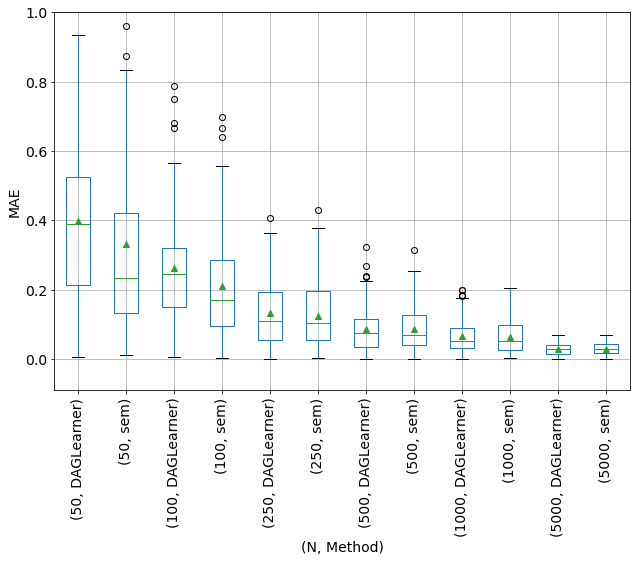

In [8]:
# import equivalent results from lavaan/R:
results_truth = pd.read_csv(os.path.join(results_fn, 'linear_many_confounders_empirical_ate.csv'))
results_df = pd.read_csv(os.path.join(results_fn, 'linear_many_confounders_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'linear_many_confounders_sem_results.csv'))

results_df_R['mae'] = abs(results_df_R['coeff'] - results_truth['emp_ate'])
results_df['mae'] = abs(results_df['coeff'] - results_truth['emp_ate'])
# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

# Create boxplots
results.boxplot(column='mae', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_linear_many_confs.png'), dpi=160)
plt.show()

# Nonlinear simple structure

In [9]:
N = [50, 100, 250, 500, 1000, 5000]
seed = 42
np.random.seed(seed)
true_empirical_ATEs = {}
results = {}
for n in N:
    print("Simulating with sample size:", n)
    estATEs = []
    true_emps = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types,Y1,Y0  = gen_simple_nonlinear_confounder(n)
        true_emps.append((Y1-Y0).mean())
        df.to_csv(os.path.join(data_fn, 'simple_nonlinear_confounder_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG,k=k, var_types=var_types, save_models=False)
        # fit the daglearner:
        daglearner.fit(data=df,  verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        estATEs.append(estATE)
    estATEs = np.asarray(estATEs)    
    results[n] = estATEs
    true_emps = np.asarray(true_emps)
    true_empirical_ATEs[n] = true_emps

results_df = []
for N, coeffs in results.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_daglearner_results.csv'), index=False) 

true_df = []
for N, ates in true_empirical_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_empirical_ate.csv'), index=False) 

Simulating with sample size: 50
Simulating with sample size: 100
Simulating with sample size: 250
Simulating with sample size: 500
Simulating with sample size: 1000
Simulating with sample size: 5000


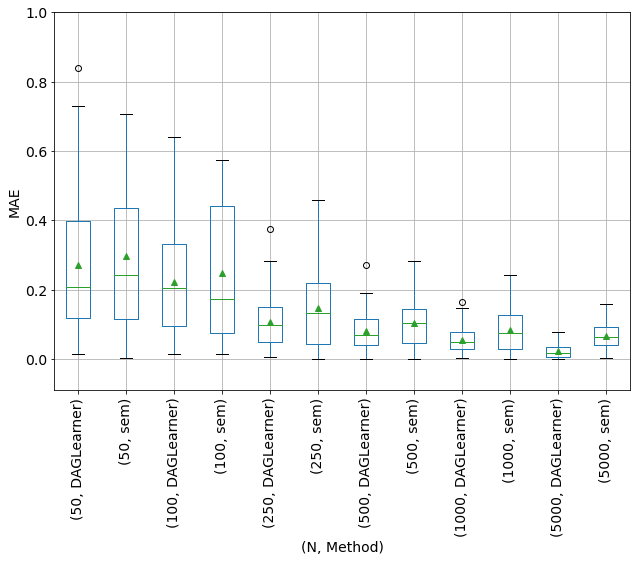

In [10]:
# import equivalent results from lavaan/R:
results_truth = pd.read_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_empirical_ate.csv'))
results_df = pd.read_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_sem_results.csv'))
results_df_R['mae'] = abs(results_df_R['coeff'] - results_truth['emp_ate'])
results_df['mae'] = abs(results_df['coeff'] - results_truth['emp_ate'])
# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

# Create boxplots
results.boxplot(column='mae', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_nonlinear.png'), dpi=160)
plt.show()

## Simple Mediation Model

In [8]:
N = [50, 100, 250, 500, 1000, 5000]
seed = 42
np.random.seed(seed)
true_total_ATEs = {}
true_direct_ATEs = {}
true_indirect_ATEs = {}
results_total = {}
results_direct = {}
results_indirect = {}
for n in N:
    print("Simulating with sample size:", n)
    estATEs_total = []
    estATEs_direct = []
    estATEs_indirect = []
    true_total =  1.14 # direct effect = 0.5, indirect = 0.8 * 0.8, total = 1.14
    true_direct = 0.5
    true_indirect = 0.64
    true_totals = []
    true_directs = []
    true_indirects = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types, _, _  = gen_simple_linear_mediation(n)
        true_totals.append(true_total)  # read from graph
        true_directs.append(true_direct)
        true_indirects.append(true_indirect)
        df.to_csv(os.path.join(data_fn, 'simple_mediation_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG,k=k, var_types=var_types, save_models=False)
        # fit the daglearner:
        daglearner.fit(data=df,  verbose=False)

        ## FIRST TOTAL EFFECT
        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)
        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE_total = estATE_dataset['Y']
        estATEs_total.append(estATE_total)
        
        ## SECOND X -> M  (already computed as part of intervening on X)
        estATE_xm = estATE_dataset['M']
        
        ## THIRD M -> Y  
        int_val_nodes0 = {'M': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)
        int_val_nodes1 = {'M': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE_my = estATE_dataset['Y']
        
        # note that this assumes linearity! In practice we want to explore possible nonlinear interactions
        estATE_indirect = estATE_xm*estATE_my
        estATEs_indirect.append(estATE_indirect)
        estATE_direct = estATE_total - estATE_indirect
        estATEs_direct.append(estATE_direct)
        
    estATEs_total = np.asarray(estATEs_total)
    estATEs_direct = np.asarray(estATEs_direct)   
    estATEs_indirect = np.asarray(estATEs_indirect)   
    
    results_total[n] = estATEs_total
    results_direct[n] = estATEs_direct
    results_indirect[n] = estATEs_indirect
    
    true_totals = np.asarray(true_totals)
    true_directs = np.asarray(true_directs)
    true_indirects = np.asarray(true_indirects)
    true_total_ATEs[n] = true_totals
    true_direct_ATEs[n] = true_directs
    true_indirect_ATEs[n] = true_indirects
    
results_df = []
for N, coeffs in results_total.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_mediation_daglearner_total_results.csv'), index=False) 

results_df = []
for N, coeffs in results_indirect.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_mediation_daglearner_indirect_results.csv'), index=False) 

results_df = []
for N, coeffs in results_direct.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_mediation_daglearner_direct_results.csv'), index=False) 

true_df = []
for N, ates in true_total_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_mediation_empirical_total_ate.csv'), index=False)

true_df = []
for N, ates in true_direct_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_mediation_empirical_direct_ate.csv'), index=False) 

true_df = []
for N, ates in true_indirect_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_mediation_empirical_indirect_ate.csv'), index=False) 

Simulating with sample size: 50


KeyboardInterrupt: 

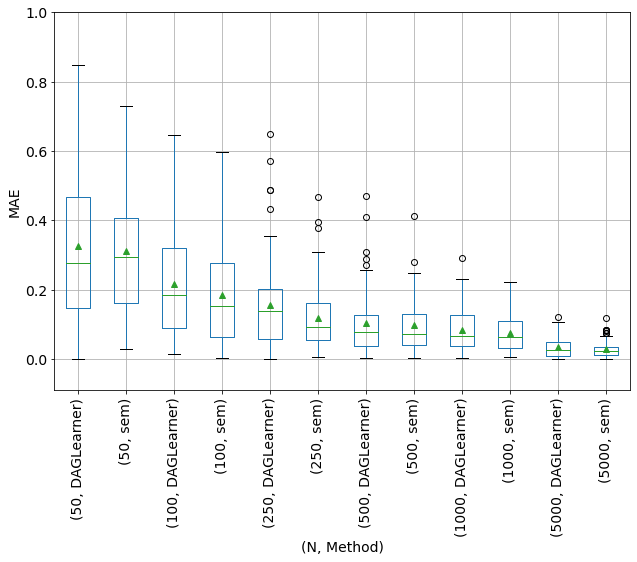

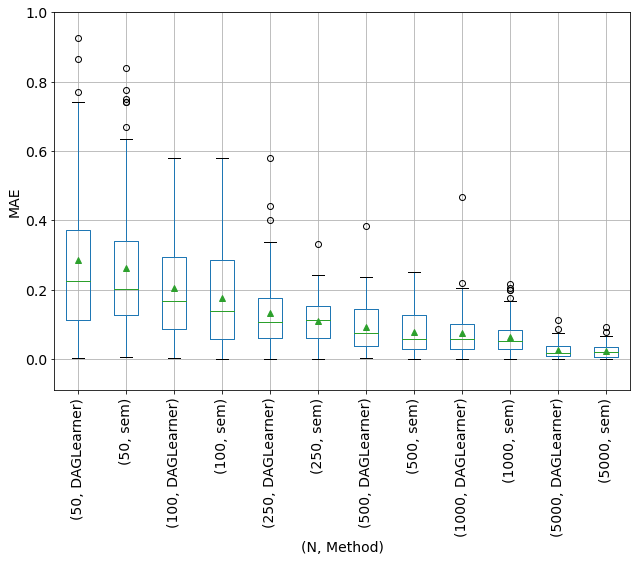

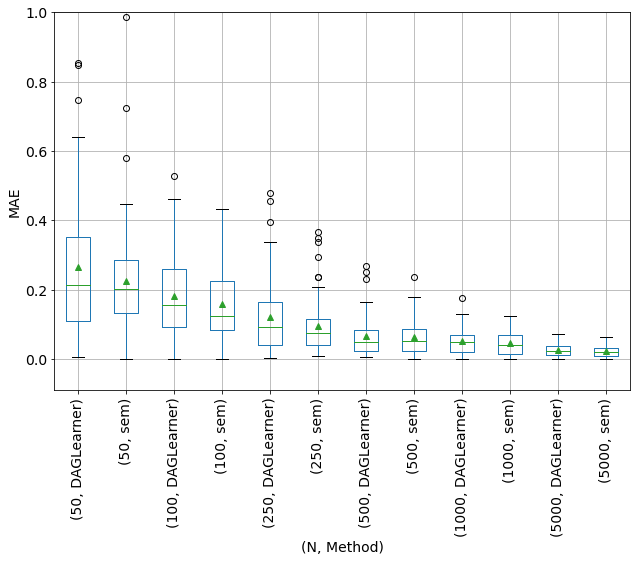

In [14]:
# import equivalent results from lavaan/R:
results_total_truth = pd.read_csv(os.path.join(results_fn, 'simple_mediation_empirical_total_ate.csv'))
results_direct_truth = pd.read_csv(os.path.join(results_fn, 'simple_mediation_empirical_direct_ate.csv'))
results_indirect_truth = pd.read_csv(os.path.join(results_fn, 'simple_mediation_empirical_indirect_ate.csv'))

results_df_total = pd.read_csv(os.path.join(results_fn, 'simple_mediation_daglearner_total_results.csv'))
results_df_direct = pd.read_csv(os.path.join(results_fn, 'simple_mediation_daglearner_direct_results.csv'))
results_df_indirect = pd.read_csv(os.path.join(results_fn, 'simple_mediation_daglearner_indirect_results.csv'))

results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_mediation_sem_results.csv'))


results_df_R['mae_total'] = abs(results_df_R['coeff_total'] - results_total_truth['emp_ate'])
results_df_total['mae_total'] = abs(results_df_total['coeff'] - results_total_truth['emp_ate'])

results_df_R['mae_direct'] = abs(results_df_R['coeff_direct'] - results_direct_truth['emp_ate'])
results_df_direct['mae_direct'] = abs(results_df_direct['coeff'] - results_direct_truth['emp_ate'])

results_df_R['mae_indirect'] = abs(results_df_R['coeff_indirect'] - results_indirect_truth['emp_ate'])
results_df_indirect['mae_indirect'] = abs(results_df_indirect['coeff'] - results_indirect_truth['emp_ate'])

# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df_total['method'] = 'DAGLearner'
results_total = pd.concat([results_df_total, results_df_R])

# combine sem and daglearner results
results_df_direct['method'] = 'DAGLearner'
results_direct = pd.concat([results_df_direct, results_df_R])

# combine sem and daglearner results
results_df_indirect['method'] = 'DAGLearner'
results_indirect = pd.concat([results_df_indirect, results_df_R])

# Create boxplots
results_total.boxplot(column='mae_total', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_mediation_total.png'), dpi=160)
plt.show()

# Create boxplots
results_direct.boxplot(column='mae_direct', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_mediation_direct.png'), dpi=160)
plt.show()


# Create boxplots
results_indirect.boxplot(column='mae_indirect', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_mediation_indirect.png'), dpi=160)
plt.show()

## Simply polynomial with varying non-linearity

In [ ]:
N = 10000
ps = np.arange(0.0001, 0.05, 0.001)
repeats = 20
seed = 42
np.random.seed(seed)
lm_results = {}
results = {}
for p in ps:
    print('Nonlinearity level:', p)
    ests = []
    params = []
    for r in range(repeats):
        df, DAG, var_types = gen_simple_poly(N=N, p=p, degree=3)
        df.to_csv(os.path.join(data_fn, 'simple_poly_N_{}_p_{}.csv'.format(N, p)), index=False)

        # Fit a linear regression model using statsmodels
        X = sm.add_constant(df[['X1', 'X2']]) # adding a constant (intercept term) to the model
        model = sm.OLS(df['Y'], X)
        summary = model.fit()

        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG,k=k, var_types=var_types, save_models=False)
        # fit the daglearn\er:
        daglearner.fit(data=df,  verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X2': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X2': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']

        params.append(summary.params['X2'])
        ests.append(estATE)
    params = np.asarray(params)
    ests = np.asarray(ests)
    lm_results[p] = params.mean()
    results[p] = ests.mean()
    
results_df = pd.DataFrame(list(results.items()), columns=['p', 'coeff'])
results_df.to_csv(os.path.join(results_fn, 'simple_poly_daglearner_results.csv'), index=False)
results_df_lm = pd.DataFrame(list(lm_results.items()), columns=['p', 'coeff'])
results_df_lm.to_csv(os.path.join(results_fn, 'simple_poly_lm_results.csv'), index=False)

Nonlinearity level: 0.0001


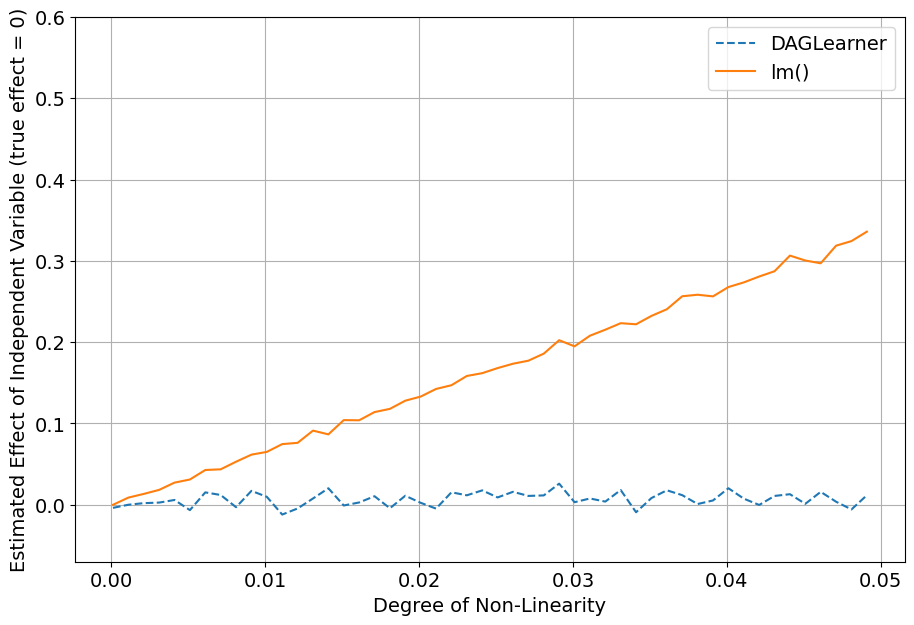

In [4]:
results_df = pd.read_csv(os.path.join(results_fn, 'simple_poly_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_poly_lm_results.csv'))

# combine sem and daglearner results
results_df_R['method'] = 'lm'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

plt.figure(figsize=(9,6))
plt.plot(results[results.method=='DAGLearner'].p, results[results.method=='DAGLearner'].coeff, ls='--',label='DAGLearner')
plt.plot(results[results.method=='lm'].p, results[results.method=='lm'].coeff, label='lm()')
plt.grid()
plt.tight_layout()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Estimated Effect of Independent Variable (true effect = 0)',fontsize=14)
plt.xlabel('Degree of Non-Linearity',fontsize=14)
plt.ylim(-0.07, 0.6)
plt.legend(fontsize=14)
plt.savefig(os.path.join(plots_fn, 'simple_poly_comparison.png'), dpi=160)
plt.show()

## Benchmark Dataset Comparisons

In [3]:

def IHDP(path="./IHDP/", reps=1):
    path_data = path
    replications = reps
    # which features are binary
    binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
    # which features are continuous
    contfeats = [i for i in range(25) if i not in binfeats]

    data = np.loadtxt(os.path.join(path_data, 'ihdp_npci_train_' + str(replications) + '.csv'), delimiter=',', skiprows=1)
    t, y = data[:, 0], data[:, 1][:, np.newaxis]
    mu_0, mu_1, x = data[:, 3][:, np.newaxis], data[:, 4][:, np.newaxis], data[:, 5:]
    true_ite = mu_1 - mu_0
    x[:, 13] -= 1
    # perm = binfeats + contfeats
    # x = x[:, perm]

    train = (x, t, y), true_ite

    data_test = np.loadtxt(path_data + '/ihdp_npci_test_' + str(replications) + '.csv', delimiter=',', skiprows=1)
    t_test, y_test = data_test[:, 0][:, np.newaxis], data_test[:, 1][:, np.newaxis]
    mu_0_test, mu_1_test, x_test = data_test[:, 3][:, np.newaxis], data_test[:, 4][:, np.newaxis], data_test[:, 5:]
    x_test[:, 13] -= 1
    # x_test = x_test[:, perm]

    true_ite_test = mu_1_test - mu_0_test
    test = (x_test, t_test, y_test), true_ite_test
    return train, test, contfeats, binfeats

### IHDP

In [5]:

path = 'data/IHDP'

eates_ws = []
eates_oos = []
pehes_ws = []
pehes_oos = []
for rep in range(1, 101):
    print('replication:', rep)
    
    train, test, contfeats, binfeats = IHDP(path=path, reps=rep)

    (x_train, t_train, y_train), true_cate_train = train
    (x_test, t_test, y_test), true_cate_test = test
    true_cate_train = true_cate_train[:, 0]
    true_cate_test = true_cate_test[:,0]
    # split train further into train and val, but keep train subsuming val (as in CEVAE). This is possible because
    # model selection does not rely on supervision (causal effect is a missing data / counterfactual problem)
    # 63/27/10 tr/va/te

    ym, ys = y_train.mean(), y_train.std()
    y_train = (y_train - ym) / ys

    print(x_train.shape, x_test.shape, t_train.shape, t_test.shape, y_train.shape, y_test.shape)

    x_train = pd.DataFrame(x_train)
    t_train = pd.DataFrame(t_train.reshape(-1,1))
    y_train = pd.DataFrame(y_train)
    all_data_train = pd.concat([t_train, x_train, y_train], axis=1)

    x_test = pd.DataFrame(x_test)
    t_test = pd.DataFrame(t_test.reshape(-1,1))
    y_test = pd.DataFrame(y_test)
    all_data_test = pd.concat([t_test, x_test, y_test], axis=1)

    X_names = ['X' + str(i) for i in range(1, x_train.shape[1]+1)]
    column_names = ['T'] + X_names + ['Y']
    all_data_train.columns = column_names  
    all_data_test.columns = column_names  


    # set var types and create graph
    var_types = {}
    i = 0
    DAGnx = nx.DiGraph()

    for var in column_names:
        if (i - 1) in binfeats:
            var_type = 'bin'
        elif var == 'T':
            var_type = 'bin'
        else:
            var_type = 'cont'
        var_types[var] = var_type
        i += 1

        if 'X' in var:
            DAGnx.add_edges_from([(var, 'T'), (var, 'Y')])

    DAGnx.add_edges_from([('T', 'Y')])

    daglearner = DAGLearner(dag=DAGnx, k=7,  var_types=var_types, save_models=False)
    daglearner.fit(data=all_data_train, verbose=False)
    int_val_nodes0 = {'T': 0}


    # oos (using test data)
    Y_0_oos = daglearner.infer(data=all_data_test, intervention_nodes_vals=int_val_nodes0)['Y']
    int_val_nodes1 = {'T': 1}
    Y_1_oos = daglearner.infer(data=all_data_test, intervention_nodes_vals=int_val_nodes1)['Y']
    # rescale
    Y_0_oos = (Y_0_oos * ys) + ym
    Y_1_oos = (Y_1_oos * ys) + ym
    cate_oos = Y_1_oos - Y_0_oos
    ate_oos =  (Y_1_oos - Y_0_oos).mean()
    eate_oos = abs(true_cate_test.mean() - ate_oos)
    epehe_oos = np.sqrt(((cate_oos - true_cate_test)**2).mean())

    # ws (using training data)
    Y_0_ws = daglearner.infer(data=all_data_train, intervention_nodes_vals=int_val_nodes0)['Y']
    int_val_nodes1 = {'T': 1}
    Y_1_ws = daglearner.infer(data=all_data_train, intervention_nodes_vals=int_val_nodes1)['Y']
    # rescale
    Y_0_ws = (Y_0_ws * ys) + ym
    Y_1_ws = (Y_1_ws * ys) + ym
    cate_ws = Y_1_ws - Y_0_ws
    ate_ws =  (Y_1_ws - Y_0_ws).mean()
    eate_ws = abs(true_cate_train.mean() - ate_ws)
    epehe_ws = np.sqrt(((cate_ws - true_cate_train)**2).mean())
    
    eates_ws.append(eate_ws)
    eates_oos.append(eate_oos)
    pehes_ws.append(epehe_ws)
    pehes_oos.append(epehe_oos)



replication: 1
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 2
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 3
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 4
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 5
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 6
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 7
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 8
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 9
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 10
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 11
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 12
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 13
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 14
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
replication: 15
(673, 25) (74, 25) (673,) (74, 1) (673, 1) (74, 1)
repl

In [9]:
print('PEHE WS:', np.asarray(pehes_ws).mean(), np.asarray(pehes_ws).std())
print('PEHE OOS:', np.asarray(pehes_oos).mean(), np.asarray(pehes_oos).std())
print('eATE WS:', np.asarray(eates_ws).mean() , np.asarray(eates_ws).std())
print('eATE OOS:', np.asarray(eates_oos).mean(), np.asarray(eates_oos).std())

PEHE WS: 0.8678259282582291 0.6606995168116357
PEHE OOS: 0.9108494827172041 0.77820976493278
eATE WS: 0.11258868986595022 0.09623620714538586
eATE OOS: 0.16661438094110292 0.1379968701643115
